# Test with library osmnx

https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873

https://osmnx.readthedocs.io/en/stable/index.html

## 0) Setup

In [115]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [116]:
# Downloading the map as a graph object
G_osmnx = ox.graph_from_bbox(north = 48.00877, south = 48.00373,
                        east = 7.84336, west = 7.83252, network_type = 'all')

# area from old osm xml file: north = 48.0081, south = 48.0048, east = 7.8391, west = 7.8357

C:\Users\Arved\AppData\Local\Temp\ipykernel_17140\3367872303.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G_osmnx = ox.graph_from_bbox(north = 48.00877, south = 48.00373,


network_type (string {"all_private", "all", "bike", "drive", "drive_service", "walk"}) – what type of street network to get if custom_filter is None

In [117]:
print('The graph has {} nodes and {} edges.'.format(G_osmnx.number_of_nodes(), G_osmnx.number_of_edges()))

The graph has 304 nodes and 743 edges.


## 1) Analyze node information

In [118]:
# get list with all possible node attributes
node_attributes = ox.graph_to_gdfs(G_osmnx, edges=False).columns
print('The following node attributes are available:')
for attr in node_attributes:
    print(f'- {attr}')

The following node attributes are available:
- y
- x
- street_count
- highway
- ref
- geometry


In [119]:
# print first node
print(list(G_osmnx.nodes(data=True))[0])

(26989181, {'y': 48.0039326, 'x': 7.8371789, 'street_count': 3})


**Remark**: These attributes are not helpful enough, because we cannot define the 'special nodes'!

## 2) Analyze edge information

In [120]:
# get list with all possible edge attributes
edge_attributes = ox.graph_to_gdfs(G_osmnx, nodes=False).columns
print('The following edge attributes are available:')
for attr in edge_attributes:
    print(f'- {attr}')

The following edge attributes are available:
- osmid
- oneway
- lanes
- ref
- name
- highway
- maxspeed
- reversed
- length
- geometry
- service
- width
- tunnel
- access
- bridge


In [121]:
# print first edge
print(list(G_osmnx.edges(data=True))[0])

(26989181, 523915341, {'osmid': 230446364, 'oneway': True, 'lanes': '1', 'ref': 'K 9860', 'name': 'Breisacher Straße', 'highway': 'secondary', 'maxspeed': '50', 'reversed': False, 'length': 28.355})


 **Remark:** Missing information from osm file {'surface': 'asphalt'}.

## 3) Plot

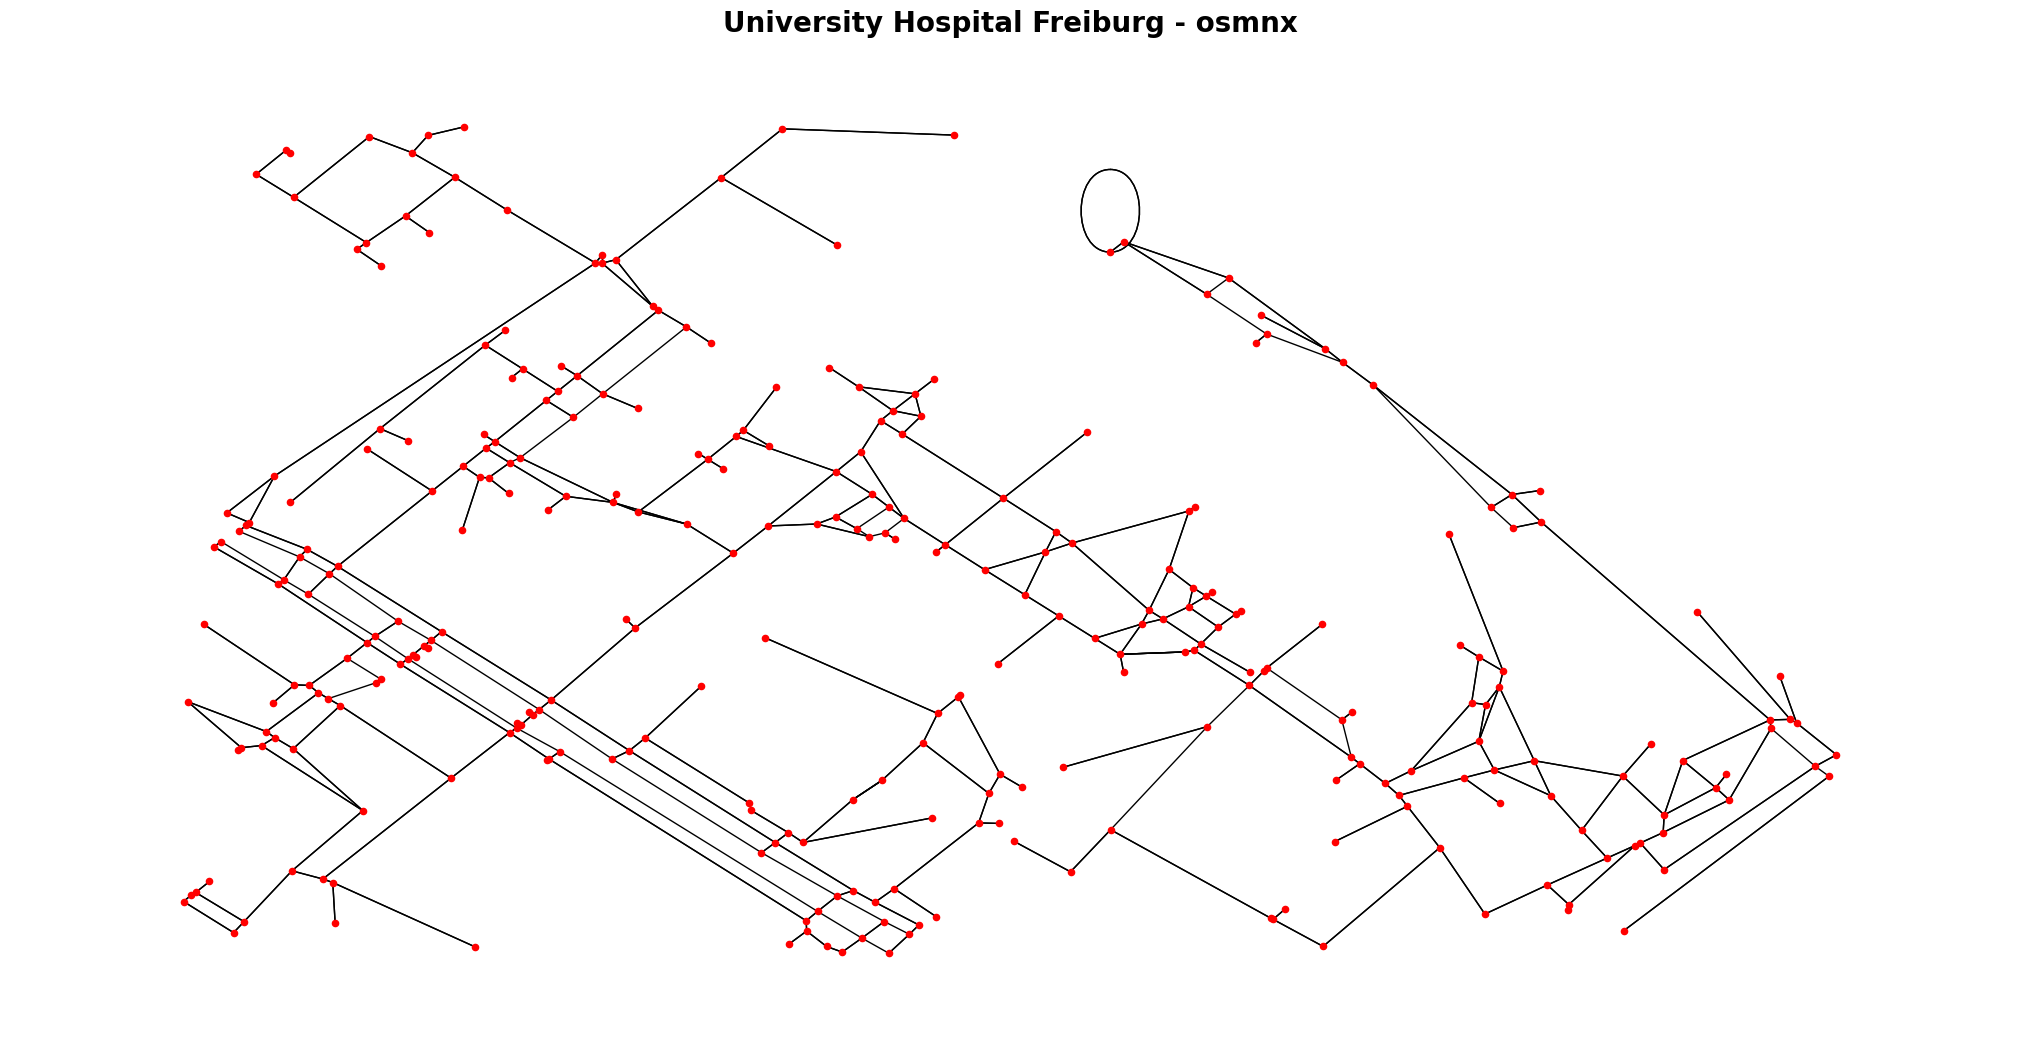

In [122]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_osmnx.nodes(data=True)}

plt.figure(figsize=(20, 10))
nx.draw(G_osmnx, with_labels=False, node_size=20, node_color='red', edge_color='black', pos=pos, arrows=False)
plt.title('University Hospital Freiburg - osmnx', fontsize=20, fontweight='bold')
plt.show()

**Conclusion**: Use osmnx to build the graph and afterwards add missing attributes (e.g. for edges 'surface' and for nodes 'special character').

## 4) OSM XML-file

In [123]:
# reading data inside xml file to a variable under the name data
with open('Uniklinikum_Freiburg_map_v2.osm', 'r', encoding='utf-8') as f:
    data = f.read()
 
# passing stored data inside beautifulsoup parser, storing the returned object 
bs_data = BeautifulSoup(data, "xml")

In [124]:
# store all nodes in a dictionary and give them a label
nds_xml = {}
for node in bs_data.select('node'):
    # first case: store has a name
    if node.find('tag', k='name'):
        # map node id to name
        nds_xml[node['id']] = node.find('tag', k='name').get('v')
    else:
        nds_xml[node['id']] = None

# print the number of total nodes      
print('The osm-xml map includes {} total nodes before filtering.'.format(len(nds_xml.keys())))

The osm-xml map includes 6505 total nodes before filtering.


In [125]:
# print ids where value is not None
print(f'The following {len([v for k,v in nds_xml.items() if v is not None])} nodes of the xml graph have names:')
for k, v in nds_xml.items():
    if v is not None:
        print(f'- {k}: {v}')

The following 77 nodes of the xml graph have names:
- 27666886: Freiburg Klinikum
- 31413757: Robert-Koch-Straße
- 31683485: Robert-Koch-Straße
- 31683731: Rathaus im Stühlinger
- 365981022: The Holy Taco Shack
- 388528852: Emmaus Kapelle
- 611622282: Rathaus im Stühlinger
- 660196439: Robert-Koch-Straße
- 660196451: Robert-Koch-Straße
- 660196455: Robert-Koch-Straße
- 660196473: Friedrich-Ebert-Platz
- 1280377548: Apotheke des Universitätsklinikums
- 1280377565: Neurozentrum
- 1280377702: Café am Ring
- 1585856123: Die Andere Galerie
- 1854588738: Augenklinik / HNO
- 2401035988: Tonus
- 2450284435: Neurozentrum
- 2521121976: Café am Eck
- 2545781182: Bistro am Lorenzring
- 2926060012: Robert-Koch-Straße
- 3137144829: Berliner Allee
- 3137144830: Berliner Allee
- 3137144831: Killianstraße
- 3137144832: Killianstraße
- 3350449602: Urologie
- 3378944507: Luther Kindergarten
- 3436131035: Kiosk Frauenklinik
- 5327549888: Ernährungsmedizin
- 5327549890: Medienzentrum
- 5861976267: Reiß-Bec

In [126]:
# create graph with all nodes from xml file
G_xml = nx.Graph()
for node in bs_data.select('node'):
    G_xml.add_node(node['id'], y = float(node['lat']), x = float(node['lon']), street_count = None)

In [127]:
print(list(G_xml.nodes(data=True))[0])

('26989179', {'y': 48.0070115, 'x': 7.8312116, 'street_count': None})


In [128]:
# store all ways in a dictionary and give them a label according to their surface type
ways = {}
for way in bs_data.select('way'):
    # filter out ways that don't have a highway tag
    if way.find('tag', k='surface'):
        # map way id to a tuple of (list of node ids, highway type)
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           way.find('tag', k='surface').get('v'))
    else:
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           None)

In [129]:
# create graph with all edges from xml file
for way_id, (nodes, surface) in ways.items():
    for i in range(len(nodes)-1):
        G_xml.add_edge(nodes[i], nodes[i+1], surface = surface)

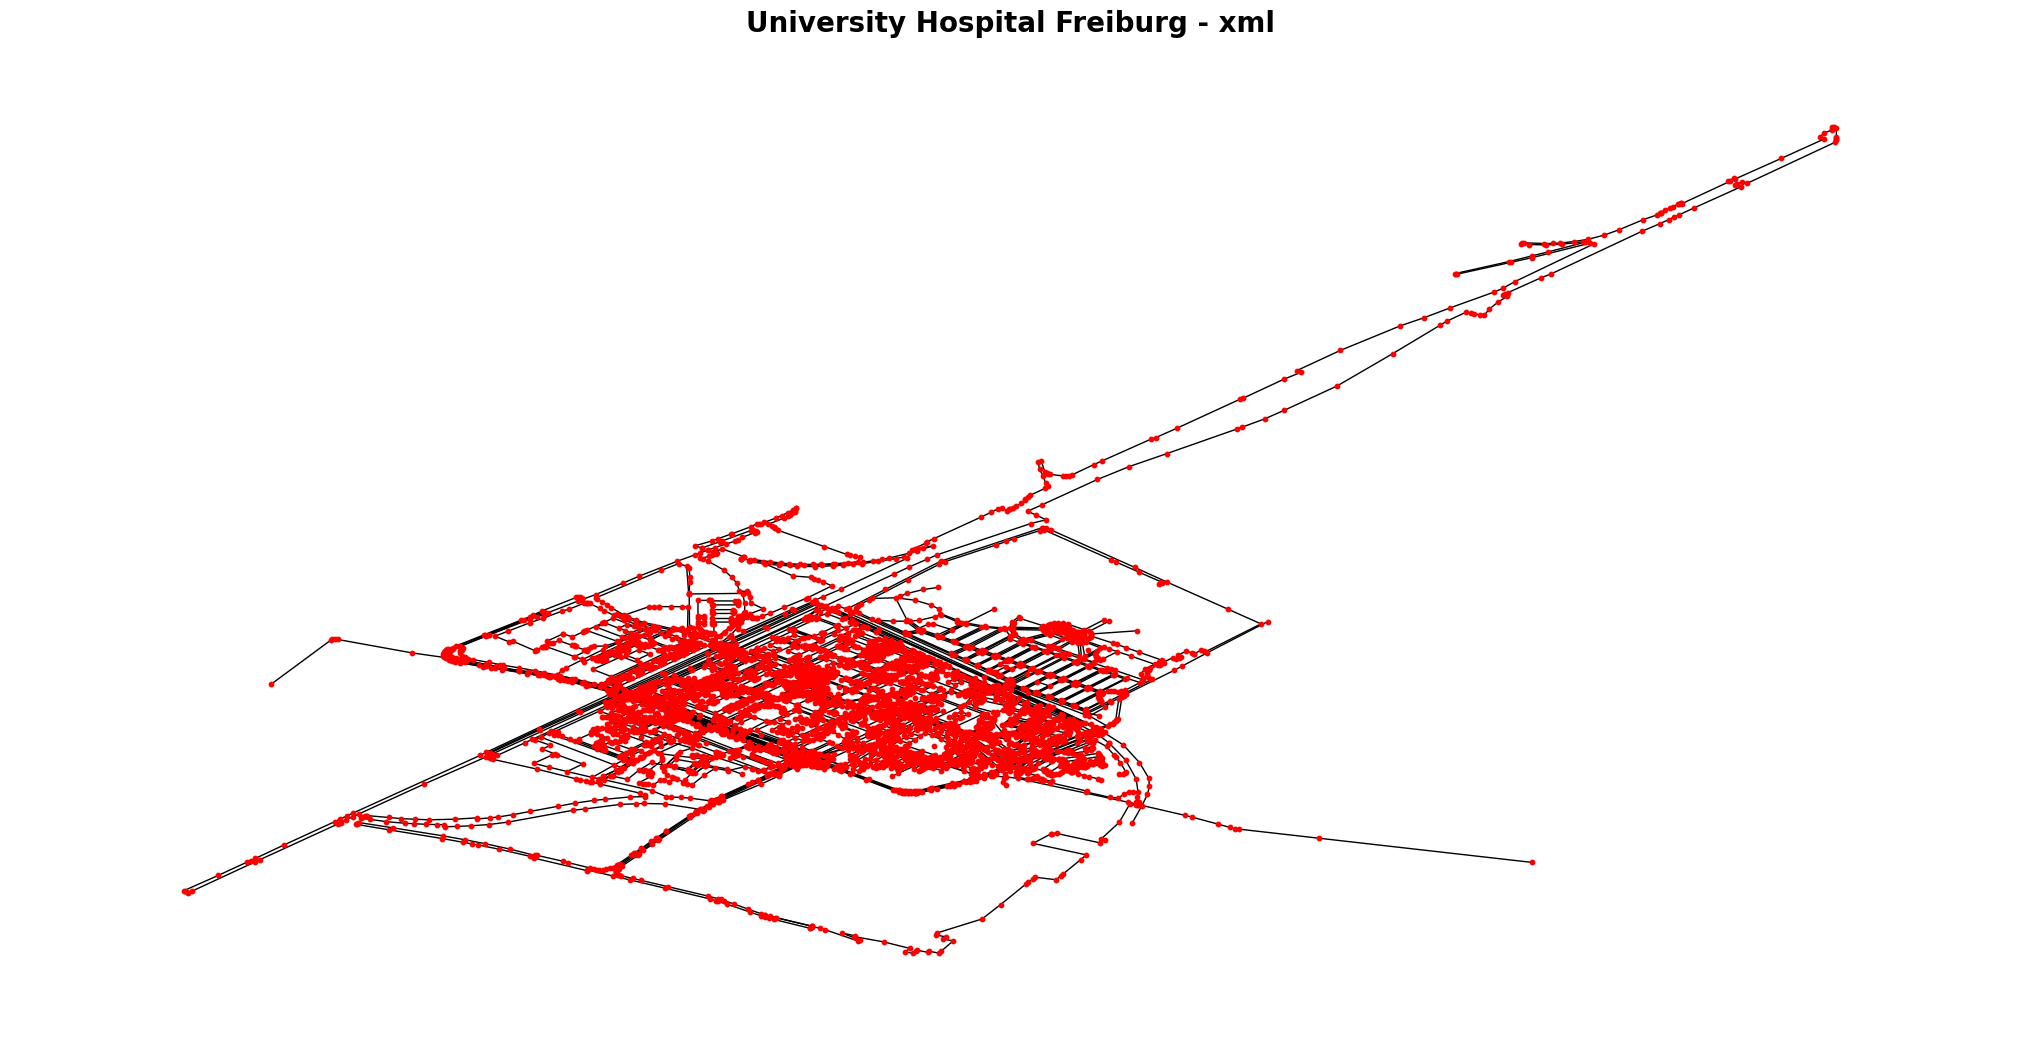

In [130]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_xml.nodes(data=True)}

plt.figure(figsize=(20, 10))
nx.draw(G_xml, with_labels=False, node_size=10, node_color='red', edge_color='black', pos=pos, arrows=False)
plt.title('University Hospital Freiburg - xml', fontsize=20, fontweight='bold')
plt.show()

## 5) Graph adaption

In [131]:
# now filter the nodes to only include those that are part of the osmnx graph
nds_final = {k: v for k, v in nds_xml.items() if int(k) in G_osmnx.nodes}

# print the number of total nodes      
print('The map includes {} total nodes after filtering.'.format(len(nds_final.keys())))

The map includes 304 total nodes after filtering.


In [133]:
# print ids where value is not None
print(f'The following {len([v for k,v in nds_final.items() if v is not None])} nodes of the osmnx graph have names:')
for k, v in nds_final.items():
    if v is not None:
        print(f'- {k}: {v}')

The following 7 nodes of the osmnx graph have names:
- 1280377565: Neurozentrum
- 1854588738: Augenklinik / HNO
- 2450284435: Neurozentrum
- 3350449602: Urologie
- 7047823175: Klinik für Frauenheilkunde
- 7108797192: Klinik für Frauenheilkunde
- 7120285980: Notaufnahme


In [137]:
# add special nodes from xml graph
special_nodes_xml_index = [k for k,v in nds_xml.items() if v is not None]
special_nodes_xml_names = [v for k,v in nds_xml.items() if v is not None]


# manually delete the nodes 'Berliner Allee' [2x] and 'Rathaus im Stühlinger' [2x] as they are too far away
special_nodes_xml_index.remove('3137144829')
special_nodes_xml_index.remove('3137144830')
special_nodes_xml_names.remove('Berliner Allee')
special_nodes_xml_index.remove('31683731')
special_nodes_xml_index.remove('611622282')
special_nodes_xml_names.remove('Rathaus im Stühlinger')

In [140]:
# create final graph
G_final = G_osmnx.copy()

# add special nodes from xml graph
for i in range(len(special_nodes_xml_index)):
    G_final.add_node(special_nodes_xml_index[i],
                     y = float(bs_data.find('node', id=special_nodes_xml_index[i])['lat']),
                     x = float(bs_data.find('node', id=special_nodes_xml_index[i])['lon']),
                     name = special_nodes_xml_names[i])

In [145]:
G_final.nodes(data=True)

NodeDataView({26989181: {'y': 48.0039326, 'x': 7.8371789, 'street_count': 3}, 27010894: {'y': 48.0086866, 'x': 7.833868, 'street_count': 3}, 27010898: {'y': 48.0083187, 'x': 7.8333809, 'street_count': 3}, 27362932: {'y': 48.0053625, 'x': 7.8395272, 'street_count': 4}, 27594973: {'y': 48.0085884, 'x': 7.8341441, 'street_count': 3}, 27673813: {'y': 48.0044886, 'x': 7.8386348, 'street_count': 3}, 27794974: {'y': 48.0062328, 'x': 7.832915, 'street_count': 3}, 29077986: {'y': 48.0043798, 'x': 7.8407516, 'street_count': 3}, 29077987: {'y': 48.003782, 'x': 7.8400014, 'street_count': 3}, 29077988: {'y': 48.0039527, 'x': 7.8396654, 'street_count': 3}, 31404358: {'y': 48.0075339, 'x': 7.835907, 'street_count': 3}, 31404360: {'y': 48.0076346, 'x': 7.8357264, 'street_count': 3}, 31404363: {'y': 48.0072872, 'x': 7.8368261, 'street_count': 1}, 31404364: {'y': 48.0070265, 'x': 7.8372346, 'street_count': 4}, 31404367: {'y': 48.007171, 'x': 7.8370138, 'street_count': 3}, 31413125: {'y': 48.0082059, 'x'

In [148]:
# add the labels to the graph
nx.set_node_attributes(G_final, nds_final, name = 'name')

# check if the labels were added
#print(list(G_final.nodes.data('name'))[0])
print(nx.get_node_attributes(G_final, 'name')) # did not always work with nx.set_node_attributes() for some reason

{'27666886': 'Freiburg Klinikum', '31413757': 'Robert-Koch-Straße', '31683485': 'Robert-Koch-Straße', '365981022': 'The Holy Taco Shack', '388528852': 'Emmaus Kapelle', '660196439': 'Rathaus im Stühlinger', '660196451': 'Robert-Koch-Straße', '660196455': 'Robert-Koch-Straße', '660196473': 'Robert-Koch-Straße', '1280377548': 'Friedrich-Ebert-Platz', '1280377565': 'Neurozentrum', '1280377702': 'Neurozentrum', '1585856123': 'Café am Ring', '1854588738': 'Augenklinik / HNO', '2401035988': 'Augenklinik / HNO', '2450284435': 'Neurozentrum', '2521121976': 'Neurozentrum', '2545781182': 'Café am Eck', '2926060012': 'Bistro am Lorenzring', '3137144831': 'Robert-Koch-Straße', '3137144832': 'Berliner Allee', '3350449602': 'Urologie', '3378944507': 'Killianstraße', '3436131035': 'Urologie', '5327549888': 'Luther Kindergarten', '5327549890': 'Kiosk Frauenklinik', '5861976267': 'Ernährungsmedizin', '5861976268': 'Medienzentrum', '5910155409': 'Reiß-Beck', '6185709507': '3SAM Tagespflege', '7047823175

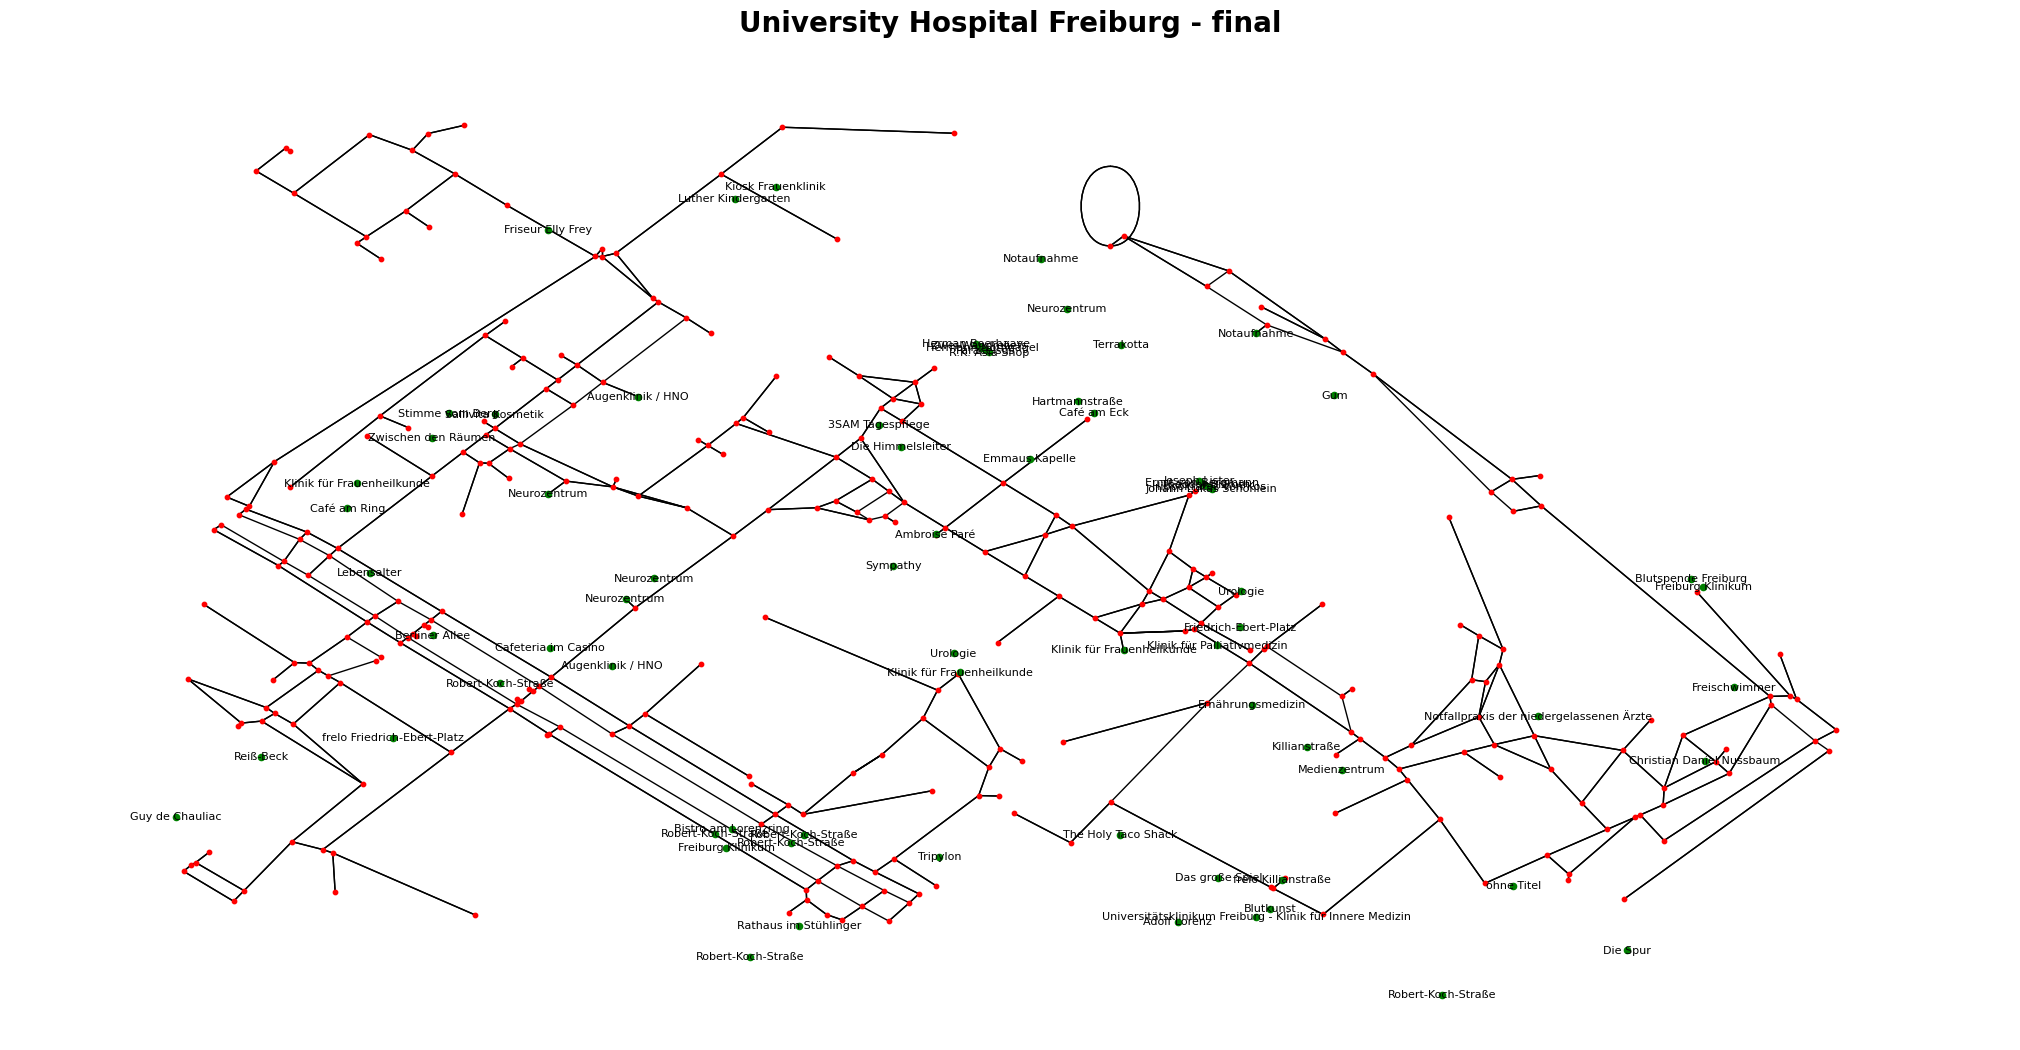

In [152]:
# plot the graph where all nodes are placed at their geographical position
pos = {node: (data['x'], data['y']) for node, data in G_final.nodes(data=True)}

# plot
plt.figure(figsize=(20, 10))
nx.draw(G_final, with_labels=False, node_size=10, node_color='red', edge_color='black', pos=pos, arrows=False)
# plot special nodes in green and label them with their name
nx.draw_networkx_nodes(G_final, nodelist = special_nodes_xml_index,
                       pos=pos, node_size=20, node_color='green')
nx.draw_networkx_labels(G_final, pos=pos, labels= nx.get_node_attributes(G_final, 'name'), font_size=8)
plt.title('University Hospital Freiburg - final', fontsize=20, fontweight='bold')
plt.show()